# 데이터 임포트

In [2]:
! mkdir data
# ! unzip /content/drive/MyDrive/projects/oden_anomalydetection/wando_sample.zip -d data

In [3]:
import pandas as pd
import ast

In [4]:
# df1 = pd.read_excel("data/wando1_oxygen(9.15~10.14).xlsx")
# df2 = pd.read_excel("data/wando2_oxygen(8.15~9.15).xlsx")
# df3 = pd.read_excel("data/wando2_oxygen(9.15~10.14).xlsx")

df1 = pd.read_excel("/content/data/wando01b_oxygen(10.23-11.1).xlsx")
df2 = pd.read_excel("/content/data/wando1_oxygen(5.23-11.1).xlsx")
df3 = pd.read_excel("/content/data/wando2_oxygen(8.15~11.1).xlsx")

In [5]:
df = pd.concat([df1, df2, df3]).reset_index(drop=True)

In [6]:
df.isnull().sum()

,0
device_id,0
device_type,0
measure_time,0
serial_number,0
coordinates,0
temperature,0
oxygen_mpl,0
oxygen_per,0
oxygen_ppm,0
timestamp,0


In [7]:
df.duplicated().sum()

0

# 데이터 전처리 및 EDA

In [8]:
import matplotlib.pyplot as plt

In [9]:
df.columns

Index(['device_id', 'device_type', 'measure_time', 'serial_number',
       'coordinates', 'temperature', 'oxygen_mpl', 'oxygen_per', 'oxygen_ppm',
       'timestamp', 'date_time'],
      dtype='object')

In [10]:
df = df[['device_id', 'date_time', 'temperature', 'oxygen_ppm']]

In [11]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [12]:
col_li = ['temperature', 'oxygen_ppm']

In [13]:
for col in col_li:
  df[col] = df[col].apply(ast.literal_eval)
  df[col] = df[col].apply(lambda x: x['value'])

In [14]:
df.dtypes

,0
device_id,object
date_time,datetime64[ns]
temperature,float64
oxygen_ppm,float64


In [15]:
pd.to_datetime(df['date_time'])

,date_time
0,2024-10-23 14:59:49
1,2024-10-23 14:58:44
2,2024-10-23 14:57:40
3,2024-10-23 14:56:36
4,2024-10-23 14:55:31
...,...
303970,2024-10-31 23:55:10
303971,2024-10-31 23:56:14
303972,2024-10-31 23:57:18
303973,2024-10-31 23:58:22


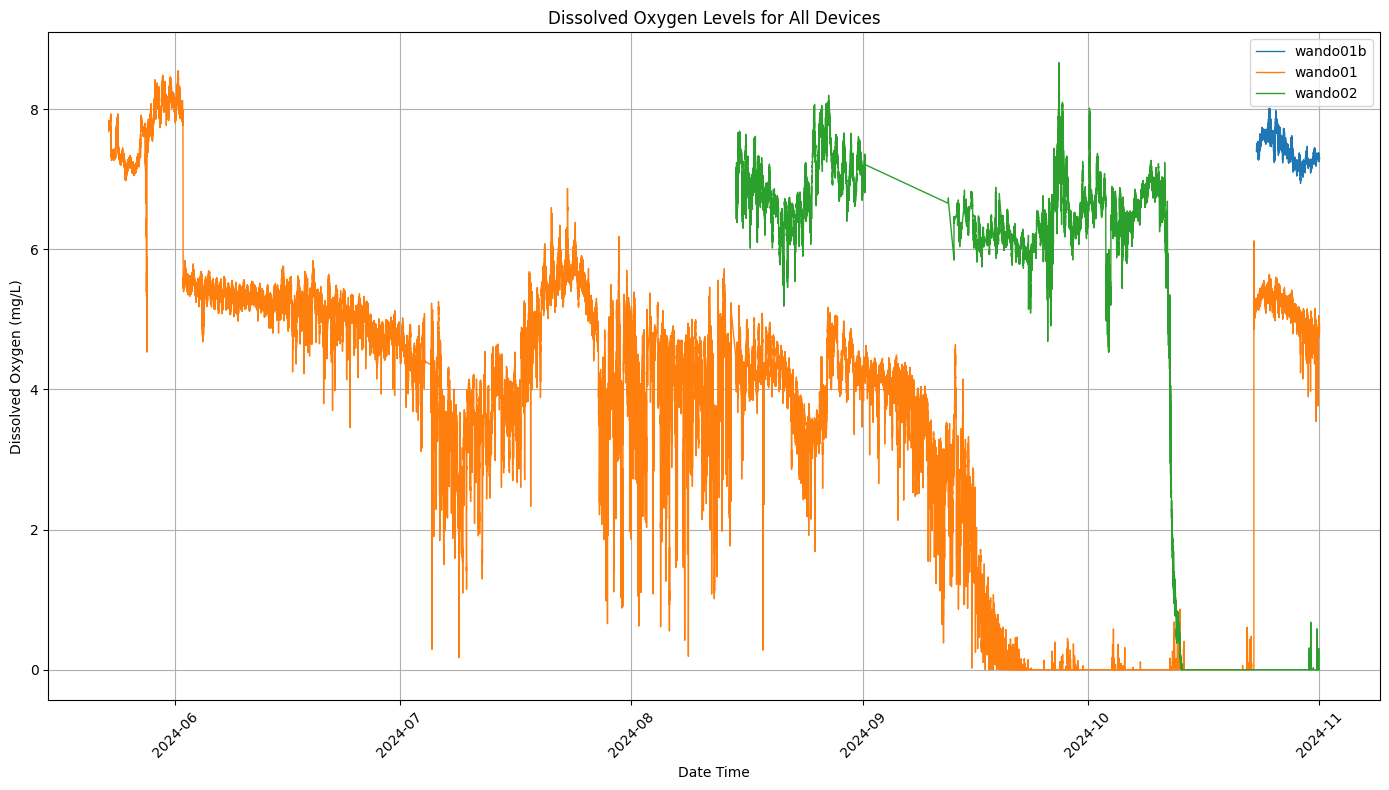

In [64]:
import matplotlib.pyplot as plt

# 그래프 설정
plt.figure(figsize=(14, 8))

# 전체 데이터를 디바이스별로 시각화
for device_id in df['device_id'].unique():
    device_data = df[df['device_id'] == device_id]

    # 모든 데이터 시각화
    plt.plot(device_data['date_time'], device_data['oxygen_ppm'], label=f'{device_id}', linewidth=1)

# 그래프 세부 설정
plt.title('Dissolved Oxygen Levels for All Devices')
plt.xlabel('Date Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


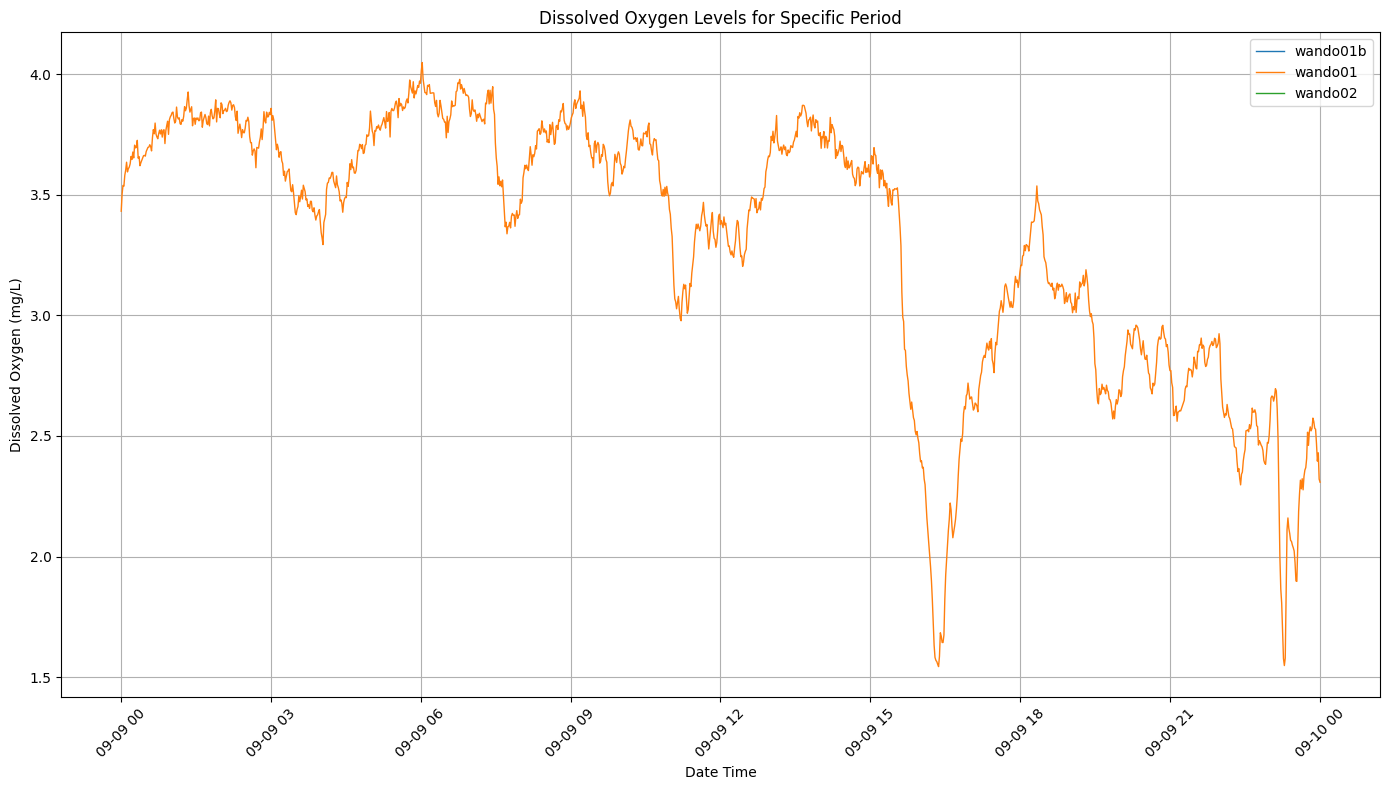

In [145]:
import matplotlib.pyplot as plt
import pandas as pd

# 특정 기간 설정 (예시: 2024-09-01 ~ 2024-10-15)
start_date = pd.Timestamp('2024-9-9')
end_date = pd.Timestamp('2024-9-10')

# 그래프 설정
plt.figure(figsize=(14, 8))

# 특정 기간 동안의 데이터를 각 디바이스별로 시각화
for device_id in df['device_id'].unique():
    device_data = df[(df['device_id'] == device_id) & (df['date_time'] >= start_date) & (df['date_time'] <= end_date)]

    # 전체 데이터 시각화
    plt.plot(device_data['date_time'], device_data['oxygen_ppm'], label=f'{device_id}', linewidth=1)

# 그래프 세부 설정
plt.title('Dissolved Oxygen Levels for Specific Period')
plt.xlabel('Date Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [70]:
#시도1

import pandas as pd
import numpy as np

# 데이터 초기화 및 설정
df['is_abnormal'] = 0

# 1. 연속적인 급격한 감소 기준 설정
drop_threshold = -0.1  # 예시 변화율 기준 (추후 데이터에 맞게 조정 가능)
sequence_length = 50   # 연속적인 감소를 판단하는 구간 길이

for device_id in df['device_id'].unique():
    device_data = df[df['device_id'] == device_id].reset_index(drop=True)

    # 변화율 계산
    device_data['oxygen_diff'] = device_data['oxygen_ppm'].diff().fillna(0)

    # 연속적인 급격한 감소 구간을 비정상으로 설정
    device_data['is_drop'] = device_data['oxygen_diff'] <= drop_threshold
    device_data['drop_sequence'] = device_data['is_drop'].astype(int).groupby((~device_data['is_drop']).cumsum()).cumsum()
    device_data.loc[device_data['drop_sequence'] >= sequence_length, 'is_abnormal'] = 1

    # 2. 낮은 산소 농도 유지 구간을 비정상으로 설정 (산소 농도 3 이하)
    device_data.loc[device_data['oxygen_ppm'] <= 3, 'is_abnormal'] = 1

    # 3. 산소 농도가 1 이하로 유지되는 구간이 100개 이상인 경우 비정상으로 설정
    device_data['low_oxygen'] = device_data['oxygen_ppm'] <= 1
    device_data['low_oxygen_duration'] = device_data['low_oxygen'].astype(int).groupby((~device_data['low_oxygen']).cumsum()).cumsum()
    device_data.loc[device_data['low_oxygen_duration'] >= 100, 'is_abnormal'] = 1

    # 결과 반영
    df.update(device_data[['is_abnormal']])

# 최종 비정상 데이터 확인
abnormal_df = df[df['is_abnormal'] == 1].copy()


In [107]:
import pandas as pd
import numpy as np

# 초기화: 비정상 여부를 나타내는 열을 0으로 설정
df['is_abnormal'] = 0

# 1. 용존산소 3 이하인 경우 비정상으로 라벨링
df['is_abnormal'] = (df['oxygen_ppm'] <= 3).astype(int)

# 2. 특정 날짜 구간의 비정상 라벨링
df.loc[(df['device_id'] == 'wando01') & (df['date_time'].between('2024-09-16', '2024-10-23 06:00:00')), 'is_abnormal'] = 1
df.loc[(df['device_id'] == 'wando02') & (df['date_time'] >= '2024-10-10 12:00:00'), 'is_abnormal'] = 1

# 3. 비정상 패턴이 나타나기 전 719개 데이터까지 라벨링할 때 중복 방지
# 중복을 방지하기 위해 한 번에 업데이트할 수 있는 배열을 생성
abnormal_flags = pd.Series(0, index=df.index)

for device_id in df['device_id'].unique():
    device_data = df[df['device_id'] == device_id].reset_index(drop=True)
    abnormal_indices = device_data[device_data['is_abnormal'] == 1].index

    for abnormal_index in abnormal_indices:
        abnormal_start_index = max(0, abnormal_index - 719)
        abnormal_flags.iloc[abnormal_start_index:abnormal_index + 1] = 1

# 중복된 인덱스를 방지하고 `is_abnormal` 열 업데이트
df['is_abnormal'] = np.maximum(df['is_abnormal'], abnormal_flags)

# 중복 인덱스 확인
if df.index.duplicated().any():
    print("Warning: Duplicate indices detected!")

# 결과 확인
print("Updated abnormal data labeling:")
print(df[df['is_abnormal'] == 1].head())


Updated abnormal data labeling:
      device_id           date_time  temperature  oxygen_ppm  is_abnormal
54554   wando01 2024-06-25 11:38:16    22.906406    5.158205            1
54555   wando01 2024-06-25 11:39:20    22.875359    5.154298            1
54556   wando01 2024-06-25 11:40:24    22.847204    5.194924            1
54557   wando01 2024-06-25 11:41:29    22.871243    5.143870            1
54558   wando01 2024-06-25 11:42:33    22.848009    5.195691            1


In [152]:
#시도3
import pandas as pd

# 초기화: 비정상 여부를 나타내는 열을 0으로 설정
df['is_abnormal'] = 0

# 1. wando01에서 9월 9일 15시 이후 비정상 라벨링 (날짜 변경)
start_date_wando01 = pd.Timestamp('2024-09-09 15:00:00')
end_date_wando01 = pd.Timestamp('2024-10-23 06:00:00')
df.loc[(df['device_id'] == 'wando01') & (df['date_time'].between(start_date_wando01, end_date_wando01)), 'is_abnormal'] = 1

# 2. wando02에서 10월 10일 이후 비정상 라벨링
start_date_wando02 = pd.Timestamp('2024-10-10 12:00:00')
df.loc[(df['device_id'] == 'wando02') & (df['date_time'] >= start_date_wando02), 'is_abnormal'] = 1

# 3. 비정상 패턴이 나타나기 전 719개 데이터까지 라벨링
# 비정상 인덱스를 찾고, 해당 인덱스 이전의 719개를 비정상으로 설정
df['abnormal_index'] = df['is_abnormal'].cumsum()  # 비정상 패턴 인덱스 마커

# 각 비정상 데이터에 대해 719개 전까지 라벨링
df['is_abnormal'] = df['is_abnormal'].rolling(window=720, min_periods=1).max()

# 마커 열 삭제
df.drop(columns=['abnormal_index'], inplace=True)

# 결과 확인
print("Updated abnormal data labeling (optimized):")
print(df[df['is_abnormal'] == 1].head())


Updated abnormal data labeling (optimized):
       device_id           date_time  temperature  oxygen_ppm  is_abnormal
150723   wando01 2024-09-09 15:00:04    27.513456    3.586874          1.0
150724   wando01 2024-09-09 15:01:09    27.512592    3.661545          1.0
150725   wando01 2024-09-09 15:02:13    27.528429    3.657747          1.0
150726   wando01 2024-09-09 15:03:17    27.536779    3.627257          1.0
150727   wando01 2024-09-09 15:04:22    27.543430    3.695122          1.0


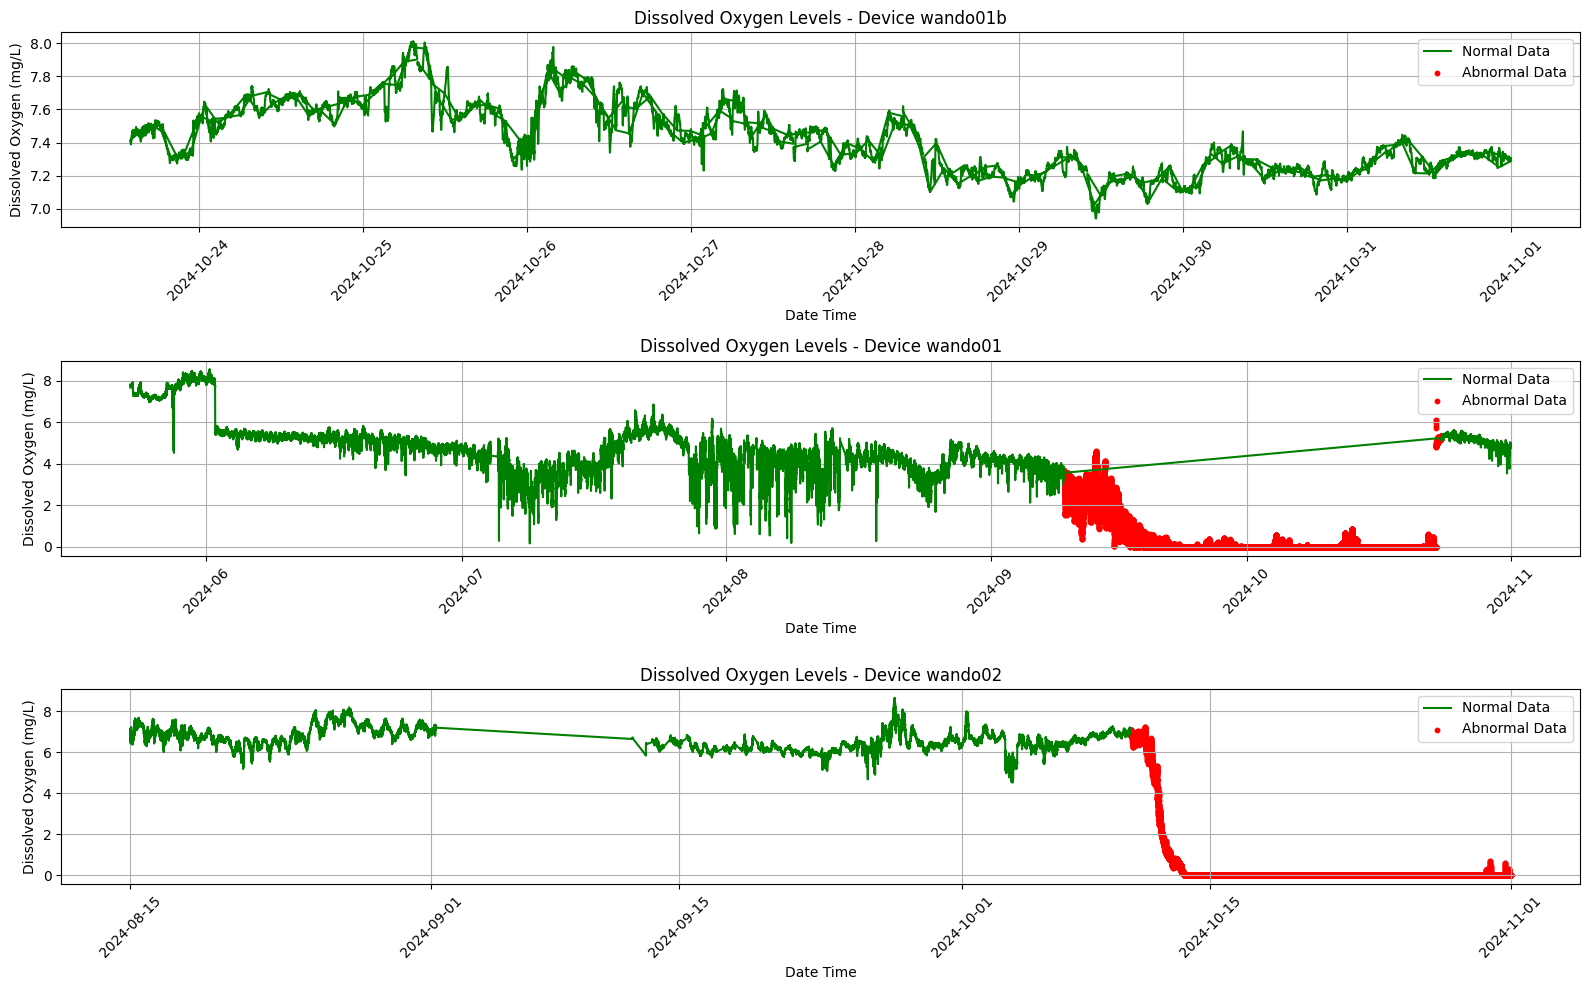

In [153]:
import matplotlib.pyplot as plt
import pandas as pd

# 디바이스별로 데이터 분리
device_ids = df['device_id'].unique()

# 그래프 설정
plt.figure(figsize=(16, 10))

for i, device_id in enumerate(device_ids, 1):
    # 디바이스별 데이터 필터링
    device_data = df[df['device_id'] == device_id]

    # 정상 데이터와 비정상 구간 필터링
    normal_data = device_data[device_data['is_abnormal'] == 0]
    abnormal_data = device_data[device_data['is_abnormal'] == 1]

    # 각 디바이스에 대한 서브플롯 생성
    plt.subplot(len(device_ids), 1, i)
    plt.plot(normal_data['date_time'], normal_data['oxygen_ppm'], label='Normal Data', color='green')
    plt.scatter(abnormal_data['date_time'], abnormal_data['oxygen_ppm'], color='red', label='Abnormal Data', s=10)

    # 그래프 세부 설정
    plt.title(f'Dissolved Oxygen Levels - Device {device_id}')
    plt.xlabel('Date Time')
    plt.ylabel('Dissolved Oxygen (mg/L)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


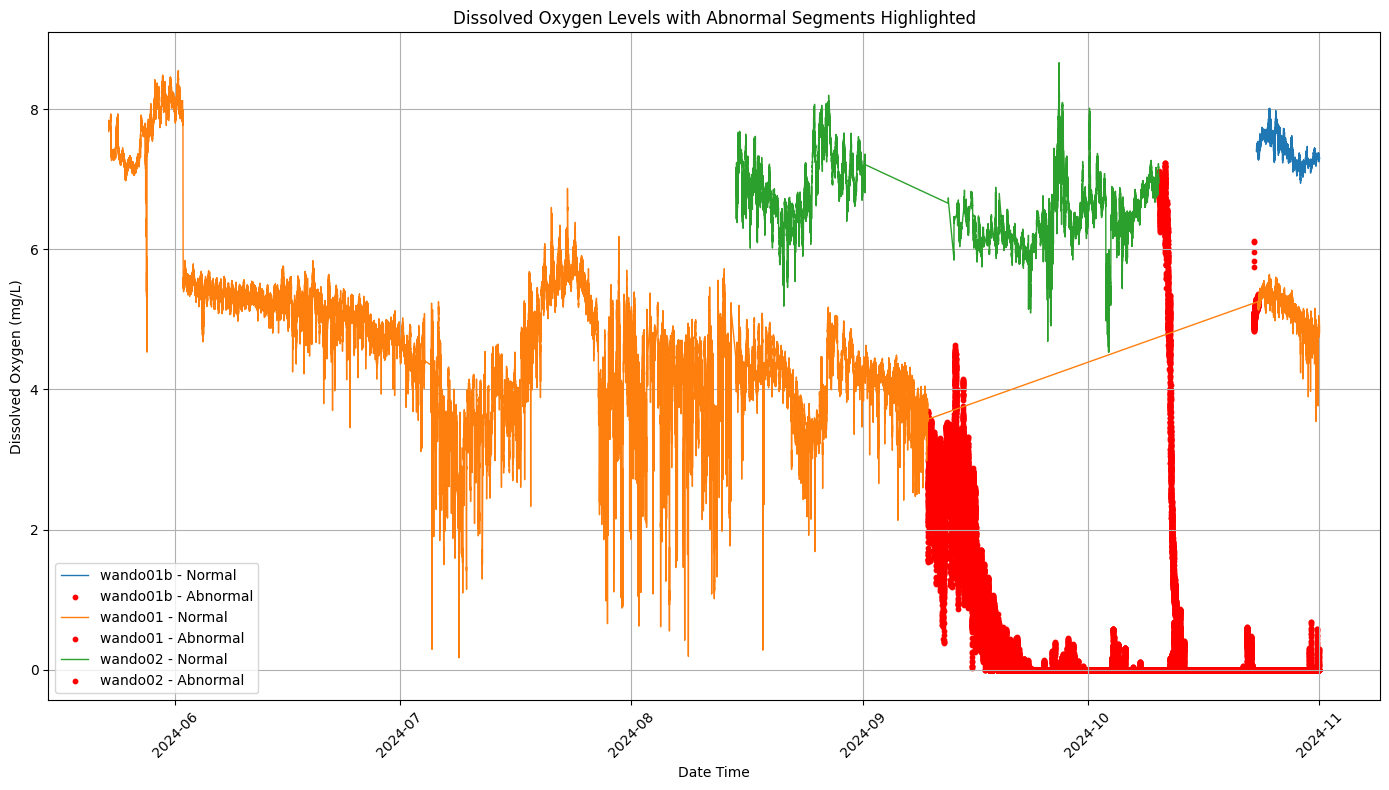

In [154]:
import matplotlib.pyplot as plt

# 그래프 설정
plt.figure(figsize=(14, 8))

# 전체 데이터를 정상/비정상 구분하여 시각화
for device_id in df['device_id'].unique():
    device_data = df[df['device_id'] == device_id]

    # 정상 구간
    normal_data = device_data[device_data['is_abnormal'] == 0]
    plt.plot(normal_data['date_time'], normal_data['oxygen_ppm'], label=f'{device_id} - Normal', linewidth=1)

    # 비정상 구간
    abnormal_data = device_data[device_data['is_abnormal'] == 1]
    plt.scatter(abnormal_data['date_time'], abnormal_data['oxygen_ppm'], label=f'{device_id} - Abnormal', color='red', s=10)

# 그래프 세부 설정
plt.title('Dissolved Oxygen Levels with Abnormal Segments Highlighted')
plt.xlabel('Date Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


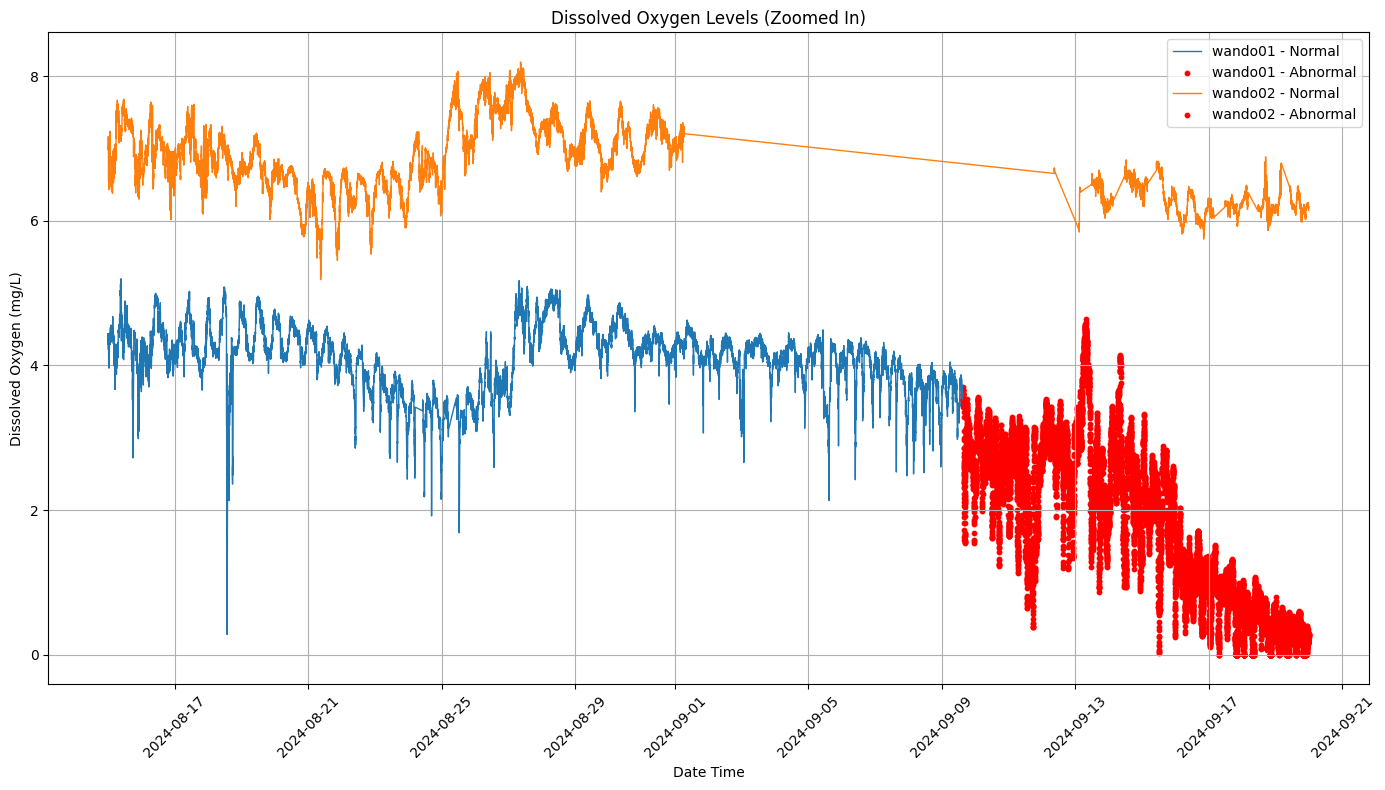

In [155]:
import matplotlib.pyplot as plt
import pandas as pd

# 특정 구간 확대 설정 (예: 9월 16일 이후의 일부분을 확대)
# 확대할 날짜 범위 (필요에 따라 조정 가능)
zoom_start_date = pd.Timestamp('2024-08-15')
zoom_end_date = pd.Timestamp('2024-09-20')

# 데이터 필터링: 확대할 날짜 범위에 해당하는 데이터만 선택
zoomed_data = df[(df['date_time'] >= zoom_start_date) & (df['date_time'] <= zoom_end_date)]

# 그래프 설정
plt.figure(figsize=(14, 8))

# 전체 데이터를 시각화하되, 급격한 감소 패턴을 가진 구간은 별도 색상으로 표시
for device_id in zoomed_data['device_id'].unique():
    device_data = zoomed_data[zoomed_data['device_id'] == device_id]

    # 정상 구간
    normal_data = device_data[(device_data['is_abnormal'] == 0)]
    plt.plot(normal_data['date_time'], normal_data['oxygen_ppm'], label=f'{device_id} - Normal', linewidth=1)

    # 비정상 구간
    abnormal_data = device_data[device_data['is_abnormal'] == 1]
    plt.scatter(abnormal_data['date_time'], abnormal_data['oxygen_ppm'], label=f'{device_id} - Abnormal', color='red', s=10)

# 그래프 세부 설정
plt.title('Dissolved Oxygen Levels (Zoomed In)')
plt.xlabel('Date Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [156]:
# abnormal_df = df[df['device_id']=="wando01"].reset_index(drop=True)
# normal_df = df[df['device_id']=="wando02"].reset_index(drop=True)

# 기존 normal_df와 abnormal_df를 유지하면서 디바이스별 데이터를 처리
normal_df = df[df['is_abnormal'] == 0].reset_index(drop=True)
abnormal_df = df[df['is_abnormal'] == 1].reset_index(drop=True)

for device_id in df['device_id'].unique():
    device_data = df[df['device_id'] == device_id]

    # 디바이스별 정상 및 비정상 데이터 추출
    device_normal_df = device_data[device_data['is_abnormal'] == 0].reset_index(drop=True)
    device_abnormal_df = device_data[device_data['is_abnormal'] == 1].reset_index(drop=True)

    # 디바이스별 정상 및 비정상 데이터 출력
    print(f"Device ID: {device_id}")
    print("Normal Data Sample for this device:")
    print(device_normal_df.head(), "\n")
    print("Abnormal Data Sample for this device:")
    print(device_abnormal_df.head(), "\n")

# 최종 전체 데이터 유지
print("Combined Normal Data Sample (existing normal_df):")
print(normal_df.head())
print("\nCombined Abnormal Data Sample (existing abnormal_df):")
print(abnormal_df.head())

Device ID: wando01b
Normal Data Sample for this device:
  device_id           date_time  temperature  oxygen_ppm  is_abnormal
0  wando01b 2024-10-23 14:59:49    20.533854    7.479515          0.0
1  wando01b 2024-10-23 14:58:44    20.621859    7.458779          0.0
2  wando01b 2024-10-23 14:57:40    20.535547    7.473933          0.0
3  wando01b 2024-10-23 14:56:36    20.675404    7.451449          0.0
4  wando01b 2024-10-23 14:55:31    20.593584    7.464531          0.0 

Abnormal Data Sample for this device:
Empty DataFrame
Columns: [device_id, date_time, temperature, oxygen_ppm, is_abnormal]
Index: [] 

Device ID: wando01
Normal Data Sample for this device:
  device_id           date_time  temperature  oxygen_ppm  is_abnormal
0   wando01 2024-05-23 02:18:28    23.655396    7.678514          0.0
1   wando01 2024-05-23 02:20:00    23.655336    7.711918          0.0
2   wando01 2024-05-23 02:21:33    23.651709    7.787882          0.0
3   wando01 2024-05-23 02:23:05    23.648855    7.8

In [157]:
print(abnormal_df.head())

  device_id           date_time  temperature  oxygen_ppm  is_abnormal
0   wando01 2024-09-09 15:00:04    27.513456    3.586874          1.0
1   wando01 2024-09-09 15:01:09    27.512592    3.661545          1.0
2   wando01 2024-09-09 15:02:13    27.528429    3.657747          1.0
3   wando01 2024-09-09 15:03:17    27.536779    3.627257          1.0
4   wando01 2024-09-09 15:04:22    27.543430    3.695122          1.0


In [158]:
# Check for duplicate indices in the provided dataframes
abnormal_duplicates = abnormal_df.index[abnormal_df.index.duplicated()].unique()
normal_duplicates = normal_df.index[normal_df.index.duplicated()].unique()

# Display the duplicate indices
abnormal_duplicates, normal_duplicates


(Index([], dtype='int64'), Index([], dtype='int64'))

In [159]:
# 중복 인덱스 확인 및 출력
abnormal_duplicates = abnormal_df.index[abnormal_df.index.duplicated()].unique()
normal_duplicates = normal_df.index[normal_df.index.duplicated()].unique()

print("Duplicate indices in abnormal_df:")
print(abnormal_duplicates)

print("Duplicate indices in normal_df:")
print(normal_duplicates)


Duplicate indices in abnormal_df:
Index([], dtype='int64')
Duplicate indices in normal_df:
Index([], dtype='int64')


In [160]:
# abnormal_df에 대해 date_time이 인덱스가 아닌 경우 인덱스를 설정
if 'date_time' in abnormal_df.columns and abnormal_df.index.name != 'date_time':
    abnormal_df.set_index('date_time', inplace=True)

# 중복된 인덱스 제거
abnormal_df = abnormal_df[~abnormal_df.index.duplicated(keep='first')]

# 데이터 타입 변환
abnormal_df['temperature'] = pd.to_numeric(abnormal_df['temperature'], errors='coerce')
abnormal_df['oxygen_ppm'] = pd.to_numeric(abnormal_df['oxygen_ppm'], errors='coerce')

# 인덱스 정렬
abnormal_df.sort_index(inplace=True)

# 2분 단위로 리샘플링 (평균값을 계산)
abnormal_df = abnormal_df.resample('2min').ffill().reset_index()
abnormal_df = abnormal_df.dropna()

# normal_df에 대해 동일한 작업 수행
if 'date_time' in normal_df.columns and normal_df.index.name != 'date_time':
    normal_df.set_index('date_time', inplace=True)

# 중복된 인덱스 제거
normal_df = normal_df[~normal_df.index.duplicated(keep='first')]

# 데이터 타입 변환
normal_df['temperature'] = pd.to_numeric(normal_df['temperature'], errors='coerce')
normal_df['oxygen_ppm'] = pd.to_numeric(normal_df['oxygen_ppm'], errors='coerce')

# 인덱스 정렬
normal_df.sort_index(inplace=True)

# 2분 단위로 리샘플링 (평균값을 계산)
normal_df = normal_df.resample('2min').ffill().reset_index()
normal_df = normal_df.dropna()

# 결과 확인
print("Resampled abnormal_df:")
print(abnormal_df.head())

print("Resampled normal_df:")
print(normal_df.head())


Resampled abnormal_df:
            date_time device_id  temperature  oxygen_ppm  is_abnormal
1 2024-09-09 15:02:00   wando01    27.512592    3.661545          1.0
2 2024-09-09 15:04:00   wando01    27.536779    3.627257          1.0
3 2024-09-09 15:06:00   wando01    27.547457    3.666743          1.0
4 2024-09-09 15:08:00   wando01    27.538986    3.605149          1.0
5 2024-09-09 15:10:00   wando01    27.531799    3.623954          1.0
Resampled normal_df:
            date_time device_id  temperature  oxygen_ppm  is_abnormal
1 2024-05-23 02:20:00   wando01    23.655336    7.711918          0.0
2 2024-05-23 02:22:00   wando01    23.651709    7.787882          0.0
3 2024-05-23 02:24:00   wando01    23.648855    7.827593          0.0
4 2024-05-23 02:26:00   wando01    23.648855    7.827593          0.0
5 2024-05-23 02:28:00   wando01    23.648855    7.827593          0.0


<ipython-input-160-207204df9182>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abnormal_df['temperature'] = pd.to_numeric(abnormal_df['temperature'], errors='coerce')
<ipython-input-160-207204df9182>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abnormal_df['oxygen_ppm'] = pd.to_numeric(abnormal_df['oxygen_ppm'], errors='coerce')
<ipython-input-160-207204df9182>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

In [161]:
print(normal_df['oxygen_ppm'].quantile(0.001))
print(normal_df['oxygen_ppm'].quantile(0.01))
print(normal_df['oxygen_ppm'].quantile(0.025))
print(normal_df['oxygen_ppm'].quantile(0.05))
print(normal_df['oxygen_ppm'].quantile(0.1))
print(normal_df['oxygen_ppm'].quantile(0.2))
print(normal_df['oxygen_ppm'].quantile(0.3))

1.0311740596294403
2.197694573402405
2.7905363380908965
3.242504906654358
3.5734410285949707
4.175097179412842
4.612303209304809


In [162]:
print(abnormal_df['oxygen_ppm'].quantile(0.1))
print(abnormal_df['oxygen_ppm'].quantile(0.125))
print(abnormal_df['oxygen_ppm'].quantile(0.15))
print(abnormal_df['oxygen_ppm'].quantile(0.175))
print(abnormal_df['oxygen_ppm'].quantile(0.2))
print(abnormal_df['oxygen_ppm'].quantile(0.3))
print(abnormal_df['oxygen_ppm'].quantile(0.35))
print(abnormal_df['oxygen_ppm'].quantile(0.7))
print(abnormal_df['oxygen_ppm'].quantile(0.9))
print(abnormal_df['oxygen_ppm'].quantile(0.95))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.212385606765748
2.9057154178619387


In [163]:
normal_df.describe()

,date_time,temperature,oxygen_ppm,is_abnormal
count,116570,116570.000000,116570.000000,116570.0
mean,2024-08-12 01:08:59.999999744,24.192896,5.439562,0.0
min,2024-05-23 02:20:00,18.955603,0.181265,0.0
25%,2024-07-02 13:44:30,22.213133,4.396495,0.0
50%,2024-08-12 01:09:00,23.891082,5.326711,0.0
75%,2024-09-21 12:33:30,26.294399,6.691588,0.0
max,2024-10-31 23:58:00,41.042526,8.661695,0.0
std,NaN,2.526151,1.405354,0.0


In [164]:
abnormal_df.describe()

,date_time,temperature,oxygen_ppm,is_abnormal
count,37709,37709.000000,37709.000000,37709.0
mean,2024-10-05 19:30:00,24.612403,0.469950,1.0
min,2024-09-09 15:02:00,16.849760,0.000000,1.0
25%,2024-09-22 17:16:00,22.622053,0.000000,1.0
50%,2024-10-05 19:30:00,23.745899,0.000000,1.0
75%,2024-10-18 21:44:00,27.253380,0.132905,1.0
max,2024-10-31 23:58:00,30.058685,7.193623,1.0
std,NaN,2.741531,1.105048,0.0


,date_time,device_id,temperature,oxygen_ppm,is_abnormal
0,2024-06-28 04:24:00,wando01,21.087393,4.811741,1.0
1,2024-06-28 04:26:00,wando01,21.087393,4.811741,1.0
2,2024-06-28 04:28:00,wando01,21.087393,4.811741,1.0
3,2024-06-28 04:30:00,wando01,21.087393,4.811741,1.0
4,2024-06-28 04:32:00,wando01,21.087393,4.811741,1.0
...,...,...,...,...,...
78212,2024-10-14 19:28:00,wando01,22.598372,0.000000,1.0
78213,2024-10-14 19:30:00,wando01,22.602278,0.000000,1.0
78214,2024-10-14 19:32:00,wando01,22.590885,0.000000,1.0
78215,2024-10-14 19:34:00,wando01,22.587217,0.000000,1.0


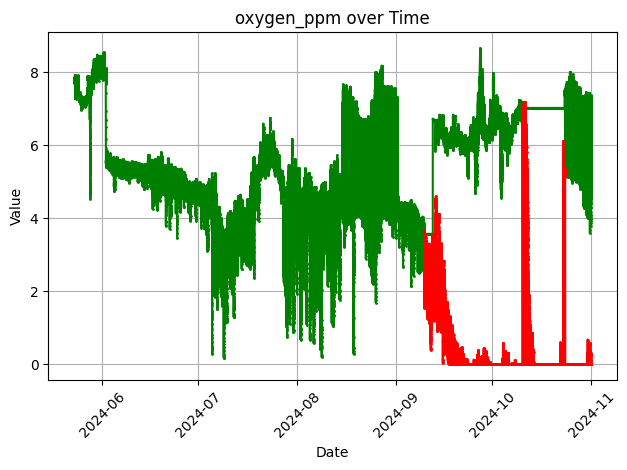

In [165]:
# 그래프 그리기
target = 'oxygen_ppm'
plt.plot(normal_df['date_time'], normal_df[target], marker='.', color='green', markersize=2)
plt.plot(abnormal_df['date_time'], abnormal_df[target], marker='.', color='red', markersize=2)
plt.title(f'{target} over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout()  # 레이아웃 조정
plt.show()

oxygen ppm이 3이하가 지속될 경우 용존산소 센서 이상일 가능성이 매우 높다.

그리고 센서 이상이 생길 시 용존산소에 급격한 변화를 보이는 것으로 추정되는데,

wando2(normal_df)의 경우에도 10월 10일 이후 센서의 이상이 확인된다.

In [166]:
#normal_df2 = normal_df[normal_df['date_time']<='2024-10-13']
normal_df2 = normal_df.copy()

In [167]:
normal_df2

,date_time,device_id,temperature,oxygen_ppm,is_abnormal
1,2024-05-23 02:20:00,wando01,23.655336,7.711918,0.0
2,2024-05-23 02:22:00,wando01,23.651709,7.787882,0.0
3,2024-05-23 02:24:00,wando01,23.648855,7.827593,0.0
4,2024-05-23 02:26:00,wando01,23.648855,7.827593,0.0
5,2024-05-23 02:28:00,wando01,23.648855,7.827593,0.0
...,...,...,...,...,...
116566,2024-10-31 23:50:00,wando01b,20.638390,7.295604,0.0
116567,2024-10-31 23:52:00,wando01b,20.640024,7.287442,0.0
116568,2024-10-31 23:54:00,wando01,20.677893,4.878502,0.0
116569,2024-10-31 23:56:00,wando01,20.666677,4.882522,0.0


# 학습용 데이터 구축

In [168]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from torch.utils.data import random_split

# Parameters
sequence_length = 720  # 하루 단위 시퀀스 (2분 단위의 720 타임 스텝)
features = ['oxygen_ppm']  # 모델 입력에 사용할 특징

# Function to create sequences from the data
def create_sequences(df, label):
    df = df.sort_values('date_time').reset_index(drop=True)
    data = df[features].values
    sequences = []
    labels = []
    num_sequences = len(data) - sequence_length + 1
    for i in range(num_sequences):
        seq = data[i:i+sequence_length]
        sequences.append(seq)
        labels.append(label)
    return sequences, labels

# 디바이스별로 시퀀스를 생성하여 각 데이터를 병합
all_normal_sequences = []
all_normal_labels = []
all_abnormal_sequences = []
all_abnormal_labels = []

for device_id in df['device_id'].unique():
    device_data = df[df['device_id'] == device_id].reset_index(drop=True)

    # Normal sequences (label=0)
    normal_data = device_data[device_data['is_abnormal'] == 0]
    normal_sequences, normal_labels = create_sequences(normal_data, label=0)
    all_normal_sequences.extend(normal_sequences)
    all_normal_labels.extend(normal_labels)

    # Abnormal sequences (label=1)
    abnormal_data = device_data[device_data['is_abnormal'] == 1]
    abnormal_sequences, abnormal_labels = create_sequences(abnormal_data, label=1)
    all_abnormal_sequences.extend(abnormal_sequences)
    all_abnormal_labels.extend(abnormal_labels)

# Combine normal and abnormal sequences
all_sequences = np.array(all_normal_sequences + all_abnormal_sequences)
all_labels = np.array(all_normal_labels + all_abnormal_labels)

# Shuffle the data
indices = np.arange(len(all_sequences))
np.random.shuffle(indices)
all_sequences = all_sequences[indices]
all_labels = all_labels[indices]

# Define PyTorch Dataset
class OxygenDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Create the dataset
dataset = OxygenDataset(all_sequences, all_labels)

# Parameters for train/validation/test split
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate lengths for each split
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size  # Ensures no leftover samples

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example usage with train DataLoader
for batch_sequences, batch_labels in train_dataloader:
    # batch_sequences shape: [batch_size, sequence_length, num_features]
    # batch_labels shape: [batch_size]
    # Here you would pass batch_sequences to your GRU model for training
    pass  # Replace with your training code

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 210266
Validation dataset size: 45057
Test dataset size: 45057


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Parameters
sequence_length = 30  # 1 hour sequences (30 time steps of 2 minutes)
features = ['oxygen_ppm']

# Function to create sequences from the data
def create_sequences(df, label):
    df = df.sort_values('date_time').reset_index(drop=True)
    data = df[features].values
    sequences = []
    labels = []
    num_sequences = len(data) - sequence_length + 1
    for i in range(num_sequences):
        seq = data[i:i+sequence_length]
        sequences.append(seq)
        labels.append(label)
    return sequences, labels

In [ ]:
# Create sequences for normal data (label=0)
normal_sequences, normal_labels = create_sequences(normal_df2, label=0)

# Create sequences for abnormal data (label=1)
abnormal_sequences, abnormal_labels = create_sequences(abnormal_df, label=1)

In [ ]:
# Combine normal and abnormal data
all_sequences = np.concatenate([normal_sequences, abnormal_sequences], axis=0)
all_labels = np.concatenate([normal_labels, abnormal_labels], axis=0)

# Shuffle the data
indices = np.arange(len(all_sequences))
np.random.shuffle(indices)
all_sequences = all_sequences[indices]
all_labels = all_labels[indices]

In [ ]:
# Define PyTorch Dataset
class OxygenDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Create the dataset
dataset = OxygenDataset(all_sequences, all_labels)

# Example usage with DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from torch.utils.data import random_split

# Parameters for train/validation/test split
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate lengths for each split
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size  # Ensures no leftover samples

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example usage with train DataLoader
for batch_sequences, batch_labels in train_dataloader:
    # batch_sequences shape: [batch_size, sequence_length, num_features]
    # batch_labels shape: [batch_size]
    # Here you would pass batch_sequences to your GRU model for training
    pass  # Replace with your training code

In [ ]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

44814 9603 9603


# AI 모델 학습

In [55]:
! mkdir checkpoint

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Epoch [1/20] Training: 100%|██████████| 3286/3286 [00:12<00:00, 255.71it/s]


Epoch [1/20], Loss: 0.1000, Accuracy: 0.9703


Epoch [1/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 568.88it/s]


Validation Loss: 0.0988, Validation Accuracy: 0.9731
Best model saved with validation loss: 0.0988


Epoch [2/20] Training: 100%|██████████| 3286/3286 [00:12<00:00, 259.34it/s]


Epoch [2/20], Loss: 0.0910, Accuracy: 0.9708


Epoch [2/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 485.96it/s]


Validation Loss: 0.0828, Validation Accuracy: 0.9728
Best model saved with validation loss: 0.0828


Epoch [3/20] Training: 100%|██████████| 3286/3286 [00:12<00:00, 258.85it/s]


Epoch [3/20], Loss: 0.0843, Accuracy: 0.9728


Epoch [3/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 426.91it/s]


Validation Loss: 0.0755, Validation Accuracy: 0.9773
Best model saved with validation loss: 0.0755


Epoch [4/20] Training: 100%|██████████| 3286/3286 [00:13<00:00, 245.45it/s]


Epoch [4/20], Loss: 0.0827, Accuracy: 0.9739


Epoch [4/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 500.04it/s]


Validation Loss: 0.0788, Validation Accuracy: 0.9760


Epoch [5/20] Training: 100%|██████████| 3286/3286 [00:12<00:00, 258.94it/s]


Epoch [5/20], Loss: 0.0840, Accuracy: 0.9729


Epoch [5/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 560.89it/s]


Validation Loss: 0.0914, Validation Accuracy: 0.9739


Epoch [6/20] Training: 100%|██████████| 3286/3286 [00:12<00:00, 258.75it/s]


Epoch [6/20], Loss: 0.0714, Accuracy: 0.9772


Epoch [6/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 569.84it/s]


Validation Loss: 0.0602, Validation Accuracy: 0.9823
Best model saved with validation loss: 0.0602


Epoch [7/20] Training: 100%|██████████| 3286/3286 [00:12<00:00, 254.43it/s]


Epoch [7/20], Loss: 0.0556, Accuracy: 0.9840


Epoch [7/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 563.15it/s]


Validation Loss: 0.0540, Validation Accuracy: 0.9862
Best model saved with validation loss: 0.0540


Epoch [8/20] Training: 100%|██████████| 3286/3286 [00:12<00:00, 256.74it/s]


Epoch [8/20], Loss: 0.0546, Accuracy: 0.9846


Epoch [8/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 562.55it/s]


Validation Loss: 0.0544, Validation Accuracy: 0.9863


Epoch [9/20] Training: 100%|██████████| 3286/3286 [00:12<00:00, 257.39it/s]


Epoch [9/20], Loss: 0.0527, Accuracy: 0.9853


Epoch [9/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 575.40it/s]


Validation Loss: 0.0562, Validation Accuracy: 0.9837


Epoch [10/20] Training: 100%|██████████| 3286/3286 [00:12<00:00, 258.53it/s]


Epoch [10/20], Loss: 0.0511, Accuracy: 0.9860


Epoch [10/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 571.60it/s]


Validation Loss: 0.0549, Validation Accuracy: 0.9850


Epoch [11/20] Training: 100%|██████████| 3286/3286 [00:12<00:00, 257.78it/s]


Epoch [11/20], Loss: 0.0482, Accuracy: 0.9869


Epoch [11/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 559.87it/s]


Validation Loss: 0.0486, Validation Accuracy: 0.9877
Best model saved with validation loss: 0.0486


Epoch [12/20] Training: 100%|██████████| 3286/3286 [00:12<00:00, 258.54it/s]


Epoch [12/20], Loss: 0.0489, Accuracy: 0.9864


Epoch [12/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 476.73it/s]


Validation Loss: 0.0604, Validation Accuracy: 0.9820


Epoch [13/20] Training: 100%|██████████| 3286/3286 [00:12<00:00, 256.94it/s]


Epoch [13/20], Loss: 0.0576, Accuracy: 0.9819


Epoch [13/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 464.95it/s]


Validation Loss: 0.0574, Validation Accuracy: 0.9834


Epoch [14/20] Training: 100%|██████████| 3286/3286 [00:13<00:00, 238.49it/s]


Epoch [14/20], Loss: 0.0520, Accuracy: 0.9855


Epoch [14/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 564.13it/s]


Validation Loss: 0.0481, Validation Accuracy: 0.9877
Best model saved with validation loss: 0.0481


Epoch [15/20] Training: 100%|██████████| 3286/3286 [00:12<00:00, 258.84it/s]


Epoch [15/20], Loss: 0.0493, Accuracy: 0.9865


Epoch [15/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 568.65it/s]


Validation Loss: 0.0726, Validation Accuracy: 0.9802


Epoch [16/20] Training: 100%|██████████| 3286/3286 [00:12<00:00, 255.89it/s]


Epoch [16/20], Loss: 0.0632, Accuracy: 0.9813


Epoch [16/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 564.26it/s]


Validation Loss: 0.0515, Validation Accuracy: 0.9876


Epoch [17/20] Training: 100%|██████████| 3286/3286 [00:12<00:00, 258.22it/s]


Epoch [17/20], Loss: 0.0542, Accuracy: 0.9855


Epoch [17/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 574.71it/s]


Validation Loss: 0.0530, Validation Accuracy: 0.9872


Epoch [18/20] Training: 100%|██████████| 3286/3286 [00:12<00:00, 256.25it/s]


Epoch [18/20], Loss: 0.0539, Accuracy: 0.9860


Epoch [18/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 567.74it/s]


Validation Loss: 0.0471, Validation Accuracy: 0.9889
Best model saved with validation loss: 0.0471


Epoch [19/20] Training: 100%|██████████| 3286/3286 [00:12<00:00, 258.20it/s]


Epoch [19/20], Loss: 0.0452, Accuracy: 0.9890


Epoch [19/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 572.02it/s]


Validation Loss: 0.0398, Validation Accuracy: 0.9918
Best model saved with validation loss: 0.0398


Epoch [20/20] Training: 100%|██████████| 3286/3286 [00:12<00:00, 254.70it/s]


Epoch [20/20], Loss: 0.0473, Accuracy: 0.9884


Epoch [20/20] Validation: 100%|██████████| 705/705 [00:01<00:00, 544.44it/s]


Validation Loss: 0.0395, Validation Accuracy: 0.9917
Best model saved with validation loss: 0.0395


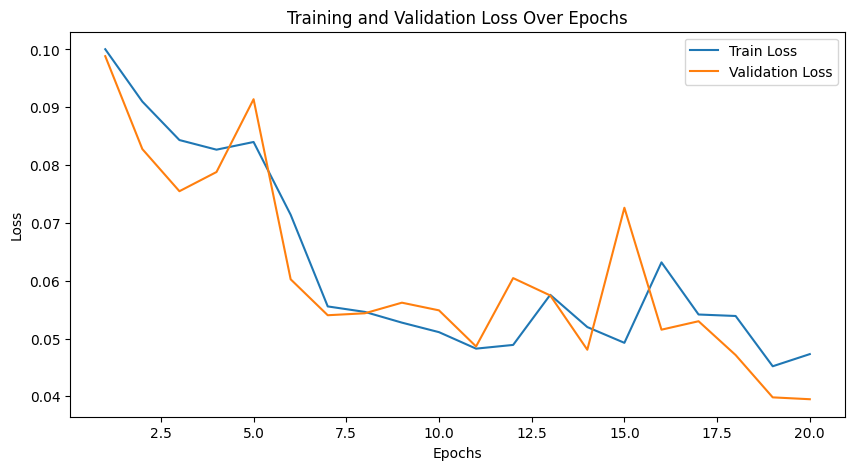

In [169]:
!mkdir -p checkpoint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Define LSTM-based model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)  # out: [batch_size, seq_len, hidden_size]
        out = self.fc(out[:, -1, :])  # Use the last time step's output
        return out

# Model parameters
input_size = len(features)  # Number of features (e.g., oxygen_ppm)
hidden_size = 32
output_size = 2  # Binary classification (normal/abnormal)
num_layers = 1
epochs = 20
learning_rate = 0.001
best_val_loss = float('inf')
best_model_path = "checkpoint/best_lstm_model.pth"

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model, define loss function and optimizer
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler to reduce learning rate if validation loss does not improve
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Early stopping parameters
early_stop_patience = 10
no_improvement_count = 0

# Lists to store loss values for plotting
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Add tqdm for training progress visualization
    train_loader_tqdm = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{epochs}] Training")
    for batch_sequences, batch_labels in train_loader_tqdm:
        batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_sequences)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == batch_labels).sum().item()
        total_predictions += batch_labels.size(0)

    # Calculate training loss and accuracy
    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        val_loader_tqdm = tqdm(val_dataloader, desc=f"Epoch [{epoch+1}/{epochs}] Validation")
        for batch_sequences, batch_labels in val_loader_tqdm:
            batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)
            outputs = model(batch_sequences)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == batch_labels).sum().item()
            total_predictions += batch_labels.size(0)

    # Calculate validation loss and accuracy
    val_epoch_loss = val_loss / len(val_dataloader)
    val_epoch_accuracy = correct_predictions / total_predictions
    val_losses.append(val_epoch_loss)
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

    # Save the best model based on validation loss
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")
        print("===============================================================================================")
        no_improvement_count = 0  # Reset early stopping counter
    else:
        no_improvement_count += 1

    # Reduce learning rate if validation loss does not improve
    scheduler.step(val_epoch_loss)

    # Early stopping check
    if no_improvement_count >= early_stop_patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


In [1]:
#바로 검증

# 검증 코드
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch

# Testing loop
all_labels = []
all_predictions = []
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
model.eval()  # Set the model to evaluation mode

# Load the best model for testing
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    print("Loaded the best model for testing.")

with torch.no_grad():  # No need to compute gradients during testing
    test_loader_tqdm = tqdm(test_dataloader, desc="Testing")
    for batch_sequences, batch_labels in test_loader_tqdm:
        batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)

        # Forward pass
        outputs = model(batch_sequences)
        loss = criterion(outputs, batch_labels)
        test_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == batch_labels).sum().item()
        total_predictions += batch_labels.size(0)

        # Collect labels and predictions for evaluation
        all_labels.extend(batch_labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate test loss and accuracy
test_epoch_loss = test_loss / len(test_dataloader)
test_epoch_accuracy = correct_predictions / total_predictions
print(f"Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(all_labels, all_predictions, target_names=['Normal', 'Abnormal'])
print("Classification Report:\n", class_report)


NameError: name 'model' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Define GRU-based model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)  # out: [batch_size, seq_len, hidden_size]
        out = self.fc(out[:, -1, :])  # Use the last time step's output
        return out

# Model parameters
input_size = len(features)  # Number of features (e.g., temperature, oxygen_ppm)
hidden_size = 32
output_size = 2  # Binary classification (normal/abnormal)
num_layers = 1
epochs = 20
learning_rate = 0.001
best_val_loss = float('inf')
best_model_path = "checkpoint/best_gru_model.pth"

In [ ]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model, define loss function and optimizer
model = GRUModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler to reduce learning rate if validation loss does not improve
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Early stopping parameters
early_stop_patience = 5
no_improvement_count = 0

# Lists to store loss values for plotting
train_losses = []
val_losses = []

Using device: cuda


In [ ]:
# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Add tqdm for training progress visualization
    train_loader_tqdm = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{epochs}] Training")
    for batch_sequences, batch_labels in train_loader_tqdm:
        batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_sequences)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == batch_labels).sum().item()
        total_predictions += batch_labels.size(0)

    # Calculate training loss and accuracy
    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        val_loader_tqdm = tqdm(val_dataloader, desc=f"Epoch [{epoch+1}/{epochs}] Validation")
        for batch_sequences, batch_labels in val_loader_tqdm:
            batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)
            outputs = model(batch_sequences)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == batch_labels).sum().item()
            total_predictions += batch_labels.size(0)

    # Calculate validation loss and accuracy
    val_epoch_loss = val_loss / len(val_dataloader)
    val_epoch_accuracy = correct_predictions / total_predictions
    val_losses.append(val_epoch_loss)
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

    # Save the best model based on validation loss
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")
        print("===============================================================================================")
        no_improvement_count = 0  # Reset early stopping counter
    else:
        no_improvement_count += 1

    # Reduce learning rate if validation loss does not improve
    scheduler.step(val_epoch_loss)

    # Early stopping check
    if no_improvement_count >= early_stop_patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

Epoch [1/20] Training: 100%|██████████| 701/701 [00:03<00:00, 218.36it/s]


Epoch [1/20], Loss: 0.0965, Accuracy: 0.9669


Epoch [1/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 905.89it/s]


Validation Loss: 0.0724, Validation Accuracy: 0.9770
Best model saved with validation loss: 0.0724


Epoch [2/20] Training: 100%|██████████| 701/701 [00:01<00:00, 354.62it/s]


Epoch [2/20], Loss: 0.0685, Accuracy: 0.9790


Epoch [2/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 970.53it/s]


Validation Loss: 0.0679, Validation Accuracy: 0.9783
Best model saved with validation loss: 0.0679


Epoch [3/20] Training: 100%|██████████| 701/701 [00:03<00:00, 211.54it/s]


Epoch [3/20], Loss: 0.0667, Accuracy: 0.9791


Epoch [3/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 662.04it/s]


Validation Loss: 0.0664, Validation Accuracy: 0.9778
Best model saved with validation loss: 0.0664


Epoch [4/20] Training: 100%|██████████| 701/701 [00:02<00:00, 277.86it/s]


Epoch [4/20], Loss: 0.0664, Accuracy: 0.9792


Epoch [4/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 628.65it/s]


Validation Loss: 0.0661, Validation Accuracy: 0.9778
Best model saved with validation loss: 0.0661


Epoch [5/20] Training: 100%|██████████| 701/701 [00:02<00:00, 235.91it/s]


Epoch [5/20], Loss: 0.0654, Accuracy: 0.9791


Epoch [5/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 888.05it/s]


Validation Loss: 0.0665, Validation Accuracy: 0.9780


Epoch [6/20] Training: 100%|██████████| 701/701 [00:01<00:00, 352.84it/s]


Epoch [6/20], Loss: 0.0644, Accuracy: 0.9794


Epoch [6/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 899.08it/s]


Validation Loss: 0.0621, Validation Accuracy: 0.9774
Best model saved with validation loss: 0.0621


Epoch [7/20] Training: 100%|██████████| 701/701 [00:01<00:00, 359.96it/s]


Epoch [7/20], Loss: 0.0632, Accuracy: 0.9791


Epoch [7/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 952.97it/s]


Validation Loss: 0.0638, Validation Accuracy: 0.9775


Epoch [8/20] Training: 100%|██████████| 701/701 [00:02<00:00, 326.94it/s]


Epoch [8/20], Loss: 0.0627, Accuracy: 0.9794


Epoch [8/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 651.16it/s]


Validation Loss: 0.0649, Validation Accuracy: 0.9782


Epoch [9/20] Training: 100%|██████████| 701/701 [00:02<00:00, 258.22it/s]


Epoch [9/20], Loss: 0.0620, Accuracy: 0.9794


Epoch [9/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 702.45it/s]


Validation Loss: 0.0666, Validation Accuracy: 0.9781


Epoch [10/20] Training: 100%|██████████| 701/701 [00:01<00:00, 350.57it/s]


Epoch [10/20], Loss: 0.0617, Accuracy: 0.9796


Epoch [10/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 805.75it/s]


Validation Loss: 0.0617, Validation Accuracy: 0.9781
Best model saved with validation loss: 0.0617


Epoch [11/20] Training: 100%|██████████| 701/701 [00:01<00:00, 352.50it/s]


Epoch [11/20], Loss: 0.0616, Accuracy: 0.9796


Epoch [11/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 947.26it/s]


Validation Loss: 0.0618, Validation Accuracy: 0.9787


Epoch [12/20] Training: 100%|██████████| 701/701 [00:02<00:00, 344.75it/s]


Epoch [12/20], Loss: 0.0617, Accuracy: 0.9793


Epoch [12/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 946.01it/s]


Validation Loss: 0.0600, Validation Accuracy: 0.9776
Best model saved with validation loss: 0.0600


Epoch [13/20] Training: 100%|██████████| 701/701 [00:01<00:00, 351.88it/s]


Epoch [13/20], Loss: 0.0623, Accuracy: 0.9790


Epoch [13/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 925.14it/s]


Validation Loss: 0.0599, Validation Accuracy: 0.9778
Best model saved with validation loss: 0.0599


Epoch [14/20] Training: 100%|██████████| 701/701 [00:02<00:00, 310.68it/s]


Epoch [14/20], Loss: 0.0608, Accuracy: 0.9796


Epoch [14/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 604.16it/s]


Validation Loss: 0.0595, Validation Accuracy: 0.9779
Best model saved with validation loss: 0.0595


Epoch [15/20] Training: 100%|██████████| 701/701 [00:03<00:00, 191.54it/s]


Epoch [15/20], Loss: 0.0607, Accuracy: 0.9796


Epoch [15/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 323.78it/s]


Validation Loss: 0.0594, Validation Accuracy: 0.9780
Best model saved with validation loss: 0.0594


Epoch [16/20] Training: 100%|██████████| 701/701 [00:02<00:00, 258.09it/s]


Epoch [16/20], Loss: 0.0603, Accuracy: 0.9794


Epoch [16/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 730.21it/s]


Validation Loss: 0.0593, Validation Accuracy: 0.9780
Best model saved with validation loss: 0.0593


Epoch [17/20] Training: 100%|██████████| 701/701 [00:02<00:00, 296.23it/s]


Epoch [17/20], Loss: 0.0598, Accuracy: 0.9795


Epoch [17/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 931.73it/s]


Validation Loss: 0.0588, Validation Accuracy: 0.9777
Best model saved with validation loss: 0.0588


Epoch [18/20] Training: 100%|██████████| 701/701 [00:02<00:00, 336.45it/s]


Epoch [18/20], Loss: 0.0593, Accuracy: 0.9796


Epoch [18/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 858.41it/s]


Validation Loss: 0.0602, Validation Accuracy: 0.9775


Epoch [19/20] Training: 100%|██████████| 701/701 [00:04<00:00, 174.66it/s]


Epoch [19/20], Loss: 0.0607, Accuracy: 0.9792


Epoch [19/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 435.51it/s]


Validation Loss: 0.0573, Validation Accuracy: 0.9790
Best model saved with validation loss: 0.0573


Epoch [20/20] Training: 100%|██████████| 701/701 [00:02<00:00, 257.72it/s]


Epoch [20/20], Loss: 0.0591, Accuracy: 0.9796


Epoch [20/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 345.31it/s]

Validation Loss: 0.0598, Validation Accuracy: 0.9783


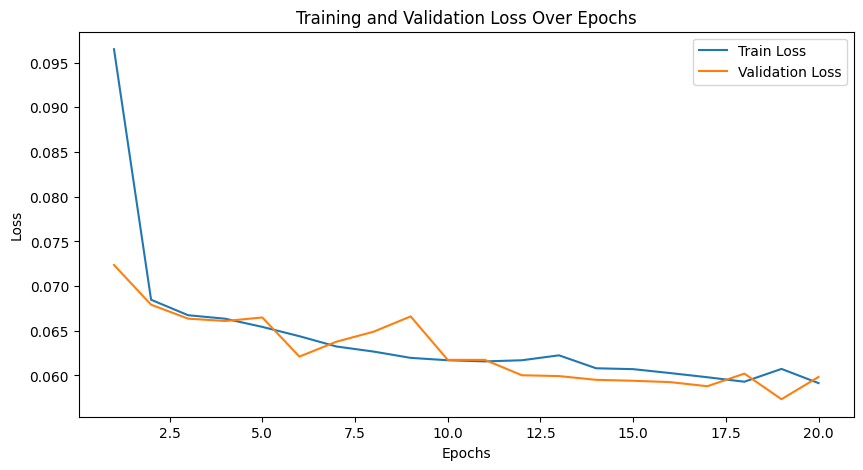

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# 검증

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
# Testing loop
all_labels = []
all_predictions = []
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
model.eval()

# Load the best model for testing
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    print("Loaded the best model for testing.")

Loaded the best model for testing.


<ipython-input-164-85e030398d66>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [ ]:
with torch.no_grad():
    test_loader_tqdm = tqdm(test_dataloader, desc="Testing")
    for batch_sequences, batch_labels in test_loader_tqdm:
        batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)
        outputs = model(batch_sequences)
        loss = criterion(outputs, batch_labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == batch_labels).sum().item()
        total_predictions += batch_labels.size(0)
        all_labels.extend(batch_labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate test loss and accuracy
test_epoch_loss = test_loss / len(test_dataloader)
test_epoch_accuracy = correct_predictions / total_predictions
print(f"Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_accuracy:.4f}")

Testing: 100%|██████████| 151/151 [00:00<00:00, 827.18it/s]

Test Loss: 0.0634, Test Accuracy: 0.9784


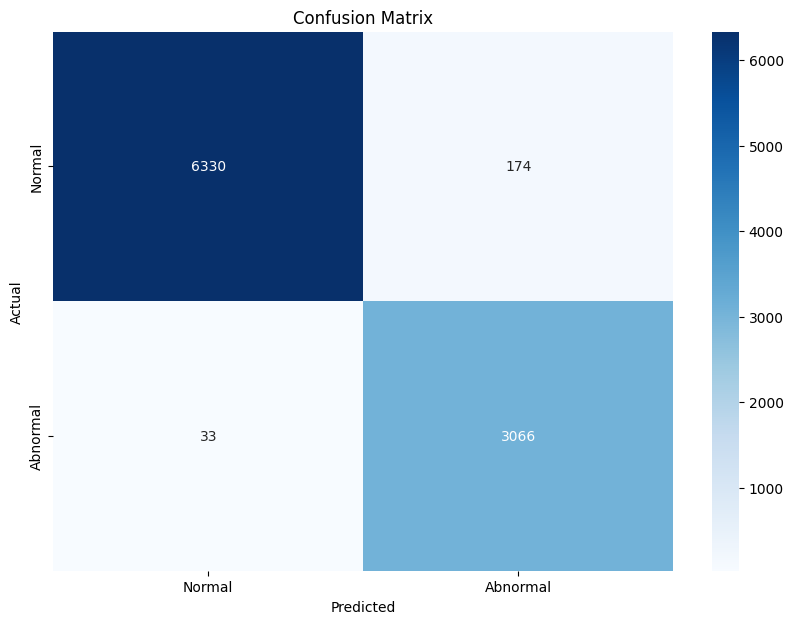

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
class_report = classification_report(all_labels, all_predictions, target_names=['Normal', 'Abnormal'])
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      0.97      0.98      6504
    Abnormal       0.95      0.99      0.97      3099

    accuracy                           0.98      9603
   macro avg       0.97      0.98      0.98      9603
weighted avg       0.98      0.98      0.98      9603



든생각 :
hidden_size
num_layers
sequence_length
learning_rate
epochs

등 AI 모델의 성능에 영향을 줄 수 있는 변수들이 많은데,
내가 한 선택이 최적이라는 것을 증명하기 위한 근거가 뒷받침 되면 좋을 것 같다.

2. 추가적인 바이오파울링 발생 데이터 확보 필요 : 평가에 신뢰도 상승